<a href="https://www.kaggle.com/code/ahmedrushdi/rl-pong-ddqn?scriptVersionId=121708427" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install gym[atari,accept-rom-license] #--quiet
!pip install pygame --quiet
!pip install pyvirtualdisplay --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.2 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Using cached libtorrent-2.0.7-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (8.6 MB)
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.5.5-py3-none-any.whl size=448838 sha256=aac6b611d21d783795c90ab7e5e183fb41ab2b22a543bfddbbadfa2eb2661f66
  Stored in directory: /root/.cache/pip/wheels/ff/91/f8/f518dfff78fedfb9076d3439fe8b08c03ced911b2fefcd385e
Successfully built AutoROM.accept-rom-license


In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()


from matplotlib import pyplot as plt, animation
%matplotlib inline
from IPython import display

def create_anim(frames, dpi, fps):
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    def setup():
        plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, init_func=setup, frames=len(frames), interval=fps)
    return anim

def display_anim(frames, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    return anim.to_jshtml()

def save_anim(frames, filename, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    anim.save(filename)

In [3]:
from IPython.display import clear_output
import gym
import numpy as np
from tqdm.notebook import tqdm
from tensorflow import keras
import tensorflow as tf
from collections import deque
import random
from keras.backend import int_shape
from tensorflow.keras.models import load_model
import psutil

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:637: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:108: DeprecationWarning: `np.object` is a deprecated ali

In [4]:
env = gym.make('PongNoFrameskip-v4')
env = gym.wrappers.AtariPreprocessing(env, noop_max=30, frame_skip=4, screen_size=84, terminal_on_life_loss=False, grayscale_obs=True, grayscale_newaxis=False, scale_obs=True)
env = gym.wrappers.FrameStack(env, 4)

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [5]:
env.action_space

Discrete(6)

In [6]:
env.observation_space

Box(0.0, 1.0, (4, 84, 84), float32)

In [7]:
# number of frames to run
NUM_FRAMES = 4000000

#number of episodes to run
NUM_EPISODES = 100

#initial episode to continue training (0 if didn't train)
INIT_EPISODE = 200

#max iterations per run
MAX_ITERATIONS = 1000


#epsilon for choosing action
eps = 1 
eps_decay = 0.99

eps = eps*(eps_decay**INIT_EPISODE)

#discount factor for future utility
discount_factor = 0.97

#batch size for exp replay
batch_size = 32

#max memory stored for exp replay
MAX_MEMORY = int(NUM_FRAMES/40)

#initial population of memory using random policy
INIT_MEMORY = int(MAX_MEMORY*0.8)

#update interval to use target network
TARGET_C = int(NUM_FRAMES/1000)

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
#         import pdb; pdb.set_trace()
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MAX_MEMORY)
        self.gamma = discount_factor    # discount rate
        self.epsilon = eps  # exploration rate
#         self.epsilon_min = eps_min
        self.epsilon_decay = eps_decay
        self.learning_rate = 0.00025
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    def _build_model(self):
        model = keras.Sequential(
            [
                keras.layers.Permute((2,3,1), input_shape=self.state_size),
                keras.layers.Conv2D(16, kernel_size=(8, 8), strides=4, activation="relu",),
                keras.layers.Conv2D(32, kernel_size=(4, 4), strides=2, activation="relu"),
                keras.layers.Flatten(),
                keras.layers.Dense(256, activation="relu"),
                keras.layers.Dense(self.action_size, activation="linear"),
            ]
        )
        model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((np.expand_dims(state, axis=0), action, reward, np.expand_dims(next_state, axis=0), done))

    #get action
    def act(self, state):
        #select random action with prob=epsilon else action=maxQ
#         import pdb; pdb.set_trace()
        state = (np.expand_dims(state, axis=0))
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values)
    
    def replay(self, batch_size):
        #sample random transitions
        
        state, action, reward, next_state, done = zip(*random.sample(self.memory, batch_size))
        state = np.concatenate(state)
        next_state = np.concatenate(next_state)
        action = np.array(action)
        reward = np.array(reward)
        done = np.array(done)
        Q_next=self.model.predict(next_state)
        states_target_q_values = self.target_model.predict(state)
        action_i = (np.arange(batch_size),action)
        n_action_i = (np.arange(batch_size),np.argmax(Q_next, axis=1))
#         import pdb; pdb.set_trace()
        target = reward + self.gamma * Q_next[n_action_i] * (1 - done)
        states_target_q_values[action_i] = target
        self.model.fit(state,states_target_q_values,epochs=1, verbose=0)
        
        
    def train(self, n_episodes, n_iterations):
        
        self.init_mem(INIT_MEMORY)
        scores = []
        iterations = []
        for i in tqdm(range(n_episodes), desc='Episodes'):
            state = env.reset()
            done = False
            score = 0
            frames = 0
            t = tqdm(range(n_iterations), leave=False, desc='iterations', total = 1000)
            for j in t:
                action = self.act(state)
                next_state, reward, done, info = env.step(action)
                self.remember(state, action, reward, next_state, done)
#                 if (j + 1)% (batch_size//4) == 0:
                self.replay(batch_size)
                if j % TARGET_C == 0:
                    
                    self.update_target_model()
                state = next_state
                score += reward
                self.epsilon *= self.epsilon_decay
                if done:
                    t.container.close()
                    iterations.append(j+1)
                    break
            scores.append(score)
            self.save_models()
            print(f'EP{i}: Done with status n_iter: {j+1}, mem_size: {len(self.memory)} {psutil.virtual_memory()}, score: {score}')
        return scores, iterations
    
    def init_mem(self, mem_n):
        for i in tqdm(range(mem_n//1000), desc = 'initializing memory'):
            state = env.reset()

            done = False
            t = tqdm(range(1000), leave=False, desc='iterations')
            for j in t:

                action = self.act(state)

                next_state, reward, done, info = env.step(action)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                if done:
                    t.container.close()
                    break
        print(len(self.memory))
                
        
    def save_models(self):
        self.model.save(f'/kaggle/working/model_{INIT_EPISODE+NUM_EPISODES}.h5')        
        self.target_model.save(f'/kaggle/working/target_model_{INIT_EPISODE+NUM_EPISODES}.h5')
    
    def load_models(self, m_link, tm_link):
        self.model = load_model(m_link)        
        self.target_model = load_model(tm_link)



In [9]:
agent = DQNAgent(env.reset().shape,env.action_space.n)
agent.load_models("../input/pongmodel/model.h5","../input/pongmodel/target_model.h5")
# agent.load_models(f"../input/pongmodel/model_{INIT_EPISODE}.h5",f"../input/pongmodel/target_model_{INIT_EPISODE}.h5")

initializing memory:   0%|          | 0/80 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

80000


Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP0: Done with status n_iter: 1000, mem_size: 81000 svmem(total=33669992448, available=13595672576, percent=59.6, used=19596140544, free=7542509568, active=1507532800, inactive=23971385344, buffers=1201176576, cached=5330165760, shared=995328, slab=500088832), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1: Done with status n_iter: 1000, mem_size: 82000 svmem(total=33669992448, available=13354971136, percent=60.3, used=19836878848, free=7281192960, active=1507840000, inactive=24227221504, buffers=1201471488, cached=5350449152, shared=995328, slab=500715520), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP2: Done with status n_iter: 1000, mem_size: 83000 svmem(total=33669992448, available=13122121728, percent=61.0, used=20069781504, free=7035166720, active=1508151296, inactive=24471552000, buffers=1201741824, cached=5363302400, shared=995328, slab=501211136), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP3: Done with status n_iter: 1000, mem_size: 84000 svmem(total=33669992448, available=12913483776, percent=61.6, used=20278370304, free=6821355520, active=1508421632, inactive=24701501440, buffers=1202012160, cached=5368254464, shared=995328, slab=501428224), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP4: Done with status n_iter: 1000, mem_size: 85000 svmem(total=33669992448, available=12639248384, percent=62.5, used=20552658944, free=6546186240, active=1508872192, inactive=24955228160, buffers=1202290688, cached=5368856576, shared=995328, slab=501678080), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP5: Done with status n_iter: 1000, mem_size: 86000 svmem(total=33669992448, available=12436955136, percent=63.1, used=20754952192, free=6343192576, active=1509134336, inactive=25170780160, buffers=1202552832, cached=5369294848, shared=995328, slab=501858304), score: -6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP6: Done with status n_iter: 1000, mem_size: 87000 svmem(total=33669992448, available=12210765824, percent=63.7, used=20981141504, free=6116397056, active=1509380096, inactive=25392848896, buffers=1202798592, cached=5369655296, shared=995328, slab=501522432), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP7: Done with status n_iter: 1000, mem_size: 88000 svmem(total=33669992448, available=11950399488, percent=64.5, used=21241479168, free=5855346688, active=1509617664, inactive=25650065408, buffers=1203036160, cached=5370130432, shared=995328, slab=501563392), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP8: Done with status n_iter: 1000, mem_size: 89000 svmem(total=33669992448, available=11738443776, percent=65.1, used=21453463552, free=5642780672, active=1509888000, inactive=25862467584, buffers=1203306496, cached=5370441728, shared=995328, slab=501710848), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP9: Done with status n_iter: 1000, mem_size: 90000 svmem(total=33669992448, available=11486683136, percent=65.9, used=21705224192, free=5390229504, active=1510174720, inactive=26106253312, buffers=1203593216, cached=5370945536, shared=995328, slab=501866496), score: -6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP10: Done with status n_iter: 1000, mem_size: 91000 svmem(total=33669992448, available=11281739776, percent=66.5, used=21910167552, free=5184737280, active=1510449152, inactive=26323972096, buffers=1203863552, cached=5371224064, shared=995328, slab=501563392), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP11: Done with status n_iter: 1000, mem_size: 92000 svmem(total=33669992448, available=11050643456, percent=67.2, used=22141255680, free=4953051136, active=1510723584, inactive=26548809728, buffers=1204142080, cached=5371543552, shared=995328, slab=501714944), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP12: Done with status n_iter: 1000, mem_size: 93000 svmem(total=33669992448, available=10803585024, percent=67.9, used=22388322304, free=4705415168, active=1511006208, inactive=26789875712, buffers=1204412416, cached=5371842560, shared=995328, slab=501882880), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP13: Done with status n_iter: 1000, mem_size: 94000 svmem(total=33669992448, available=10564603904, percent=68.6, used=22627303424, free=4465885184, active=1511276544, inactive=27022323712, buffers=1204682752, cached=5372121088, shared=995328, slab=501698560), score: -7.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP14: Done with status n_iter: 1000, mem_size: 95000 svmem(total=33669992448, available=10348109824, percent=69.3, used=22843797504, free=4248788992, active=1511538688, inactive=27245592576, buffers=1204944896, cached=5372461056, shared=995328, slab=501792768), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP15: Done with status n_iter: 1000, mem_size: 96000 svmem(total=33669992448, available=10085031936, percent=70.0, used=23106850816, free=3985272832, active=1511800832, inactive=27497795584, buffers=1205207040, cached=5372661760, shared=995328, slab=501895168), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP16: Done with status n_iter: 1000, mem_size: 97000 svmem(total=33669992448, available=9856835584, percent=70.7, used=23335071744, free=3756298240, active=1512062976, inactive=27725778944, buffers=1205469184, cached=5373153280, shared=995328, slab=502251520), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP17: Done with status n_iter: 1000, mem_size: 98000 svmem(total=33669992448, available=9645154304, percent=71.4, used=23546753024, free=3544059904, active=1512390656, inactive=27950583808, buffers=1205739520, cached=5373440000, shared=995328, slab=502026240), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP18: Done with status n_iter: 1000, mem_size: 99000 svmem(total=33669992448, available=9415450624, percent=72.0, used=23776456704, free=3313831936, active=1512660992, inactive=28174954496, buffers=1206009856, cached=5373693952, shared=995328, slab=501997568), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP19: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9172791296, percent=72.8, used=24019116032, free=3070664704, active=1512923136, inactive=28413583360, buffers=1206272000, cached=5373939712, shared=995328, slab=502165504), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP20: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9142267904, percent=72.8, used=24049639424, free=3039547392, active=1513209856, inactive=28433006592, buffers=1206554624, cached=5374251008, shared=995328, slab=502403072), score: -9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP21: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9130954752, percent=72.9, used=24060948480, free=3027709952, active=1513472000, inactive=28429836288, buffers=1206816768, cached=5374517248, shared=995328, slab=502190080), score: -8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP22: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9128103936, percent=72.9, used=24063803392, free=3024232448, active=1513742336, inactive=28429471744, buffers=1207087104, cached=5374869504, shared=995328, slab=502210560), score: -6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP23: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9142833152, percent=72.8, used=24049070080, free=3038433280, active=1514012672, inactive=28419903488, buffers=1207349248, cached=5375139840, shared=995328, slab=502480896), score: -9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP24: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9125806080, percent=72.9, used=24066101248, free=3020820480, active=1514295296, inactive=28430356480, buffers=1207623680, cached=5375447040, shared=995328, slab=502218752), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP25: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9130004480, percent=72.9, used=24061902848, free=3024429056, active=1514557440, inactive=28434006016, buffers=1207885824, cached=5375774720, shared=995328, slab=502329344), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP26: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9122332672, percent=72.9, used=24069574656, free=3016265728, active=1514819584, inactive=28431446016, buffers=1208147968, cached=5376004096, shared=995328, slab=502329344), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP27: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9155444736, percent=72.8, used=24036462592, free=3048857600, active=1515081728, inactive=28437975040, buffers=1208410112, cached=5376262144, shared=995328, slab=502489088), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP28: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9137549312, percent=72.9, used=24054358016, free=3030437888, active=1515331584, inactive=28425449472, buffers=1208659968, cached=5376536576, shared=995328, slab=502272000), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP29: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9131769856, percent=72.9, used=24060137472, free=3024035840, active=1515606016, inactive=28441001984, buffers=1208930304, cached=5376888832, shared=995328, slab=502288384), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP30: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9122799616, percent=72.9, used=24069107712, free=3014520832, active=1515945984, inactive=28442464256, buffers=1209217024, cached=5377146880, shared=995328, slab=502448128), score: -6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP31: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9134866432, percent=72.9, used=24057040896, free=3026038784, active=1516240896, inactive=28444672000, buffers=1209487360, cached=5377425408, shared=995328, slab=502530048), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP32: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9117601792, percent=72.9, used=24074305536, free=3008208896, active=1516490752, inactive=28446334976, buffers=1209737216, cached=5377740800, shared=995328, slab=502308864), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP33: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9118740480, percent=72.9, used=24073166848, free=3008770048, active=1516777472, inactive=28439629824, buffers=1210023936, cached=5378031616, shared=995328, slab=502366208), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP34: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9113079808, percent=72.9, used=24078827520, free=3002494976, active=1517056000, inactive=28444901376, buffers=1210302464, cached=5378367488, shared=995328, slab=502611968), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP35: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9135337472, percent=72.9, used=24056569856, free=3024224256, active=1517334528, inactive=28452257792, buffers=1210580992, cached=5378617344, shared=995328, slab=502386688), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP36: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9144393728, percent=72.8, used=24047513600, free=3032711168, active=1517596672, inactive=28421165056, buffers=1210843136, cached=5378924544, shared=995328, slab=502382592), score: -7.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP37: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9114279936, percent=72.9, used=24077627392, free=3002019840, active=1517858816, inactive=28459831296, buffers=1211105280, cached=5379239936, shared=995328, slab=502611968), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP38: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9124081664, percent=72.9, used=24067825664, free=3011260416, active=1518116864, inactive=28449423360, buffers=1211363328, cached=5379543040, shared=995328, slab=502898688), score: -5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP39: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9117667328, percent=72.9, used=24074240000, free=3004321792, active=1518370816, inactive=28448251904, buffers=1211617280, cached=5379813376, shared=995328, slab=502648832), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP40: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9146814464, percent=72.8, used=24045092864, free=3032879104, active=1518641152, inactive=28413734912, buffers=1211883520, cached=5380136960, shared=995328, slab=502624256), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP41: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9110978560, percent=72.9, used=24080928768, free=2996518912, active=1518911488, inactive=28467470336, buffers=1212153856, cached=5380390912, shared=995328, slab=502738944), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP42: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9101615104, percent=73.0, used=24090292224, free=2986557440, active=1519181824, inactive=28463775744, buffers=1212424192, cached=5380718592, shared=995328, slab=502964224), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP43: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9091182592, percent=73.0, used=24100720640, free=2975428608, active=1519550464, inactive=28461760512, buffers=1212698624, cached=5381144576, shared=995328, slab=502894592), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP44: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9095413760, percent=73.0, used=24096493568, free=2979115008, active=1519816704, inactive=28465057792, buffers=1212964864, cached=5381419008, shared=995328, slab=502910976), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP45: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9125425152, percent=72.9, used=24066482176, free=3008573440, active=1520095232, inactive=28430540800, buffers=1213243392, cached=5381693440, shared=995328, slab=503123968), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP46: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9131331584, percent=72.9, used=24060575744, free=3013980160, active=1520340992, inactive=28433649664, buffers=1213489152, cached=5381947392, shared=995328, slab=503255040), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP47: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9100763136, percent=73.0, used=24091144192, free=2982789120, active=1520644096, inactive=28463071232, buffers=1213734912, cached=5382324224, shared=995328, slab=503001088), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP48: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9109499904, percent=72.9, used=24082407424, free=2991054848, active=1520885760, inactive=28473380864, buffers=1213976576, cached=5382553600, shared=995328, slab=503005184), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP49: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9100734464, percent=73.0, used=24091172864, free=2981842944, active=1521106944, inactive=28467462144, buffers=1214197760, cached=5382778880, shared=995328, slab=503140352), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP50: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9096454144, percent=73.0, used=24095457280, free=2977091584, active=1521258496, inactive=28471349248, buffers=1214369792, cached=5383073792, shared=991232, slab=503365632), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP51: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9138827264, percent=72.9, used=24053080064, free=3018911744, active=1521508352, inactive=28442255360, buffers=1214599168, cached=5383401472, shared=995328, slab=503160832), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP52: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9094074368, percent=73.0, used=24097832960, free=2973634560, active=1521721344, inactive=28483235840, buffers=1214812160, cached=5383712768, shared=995328, slab=503238656), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP53: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9102254080, percent=73.0, used=24089653248, free=2981314560, active=1521938432, inactive=28478324736, buffers=1215025152, cached=5383999488, shared=995328, slab=503369728), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP54: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9080999936, percent=73.0, used=24110907392, free=2959552512, active=1522135040, inactive=28482859008, buffers=1215229952, cached=5384302592, shared=995328, slab=503226368), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP55: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9070743552, percent=73.1, used=24121163776, free=2948812800, active=1522356224, inactive=28498518016, buffers=1215430656, cached=5384585216, shared=995328, slab=503300096), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP56: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9085759488, percent=73.0, used=24106147840, free=2963345408, active=1522573312, inactive=28485070848, buffers=1215631360, cached=5384867840, shared=995328, slab=503414784), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP57: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9075122176, percent=73.0, used=24116785152, free=2952171520, active=1522761728, inactive=28490534912, buffers=1215819776, cached=5385216000, shared=995328, slab=503558144), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP58: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9082679296, percent=73.0, used=24109228032, free=2959286272, active=1522970624, inactive=28486492160, buffers=1216028672, cached=5385449472, shared=995328, slab=503279616), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP59: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9080385536, percent=73.0, used=24111521792, free=2956414976, active=1523204096, inactive=28501311488, buffers=1216262144, cached=5385793536, shared=995328, slab=503353344), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP60: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9129209856, percent=72.9, used=24062697472, free=3004776448, active=1523404800, inactive=28466978816, buffers=1216462848, cached=5386055680, shared=995328, slab=503492608), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP61: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9087168512, percent=73.0, used=24104738816, free=2962239488, active=1523605504, inactive=28499480576, buffers=1216663552, cached=5386350592, shared=995328, slab=503664640), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP62: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9061134336, percent=73.1, used=24130772992, free=2935713792, active=1523822592, inactive=28505907200, buffers=1216880640, cached=5386625024, shared=995328, slab=503275520), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP63: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9118392320, percent=72.9, used=24073515008, free=2992418816, active=1524064256, inactive=28494462976, buffers=1217122304, cached=5386936320, shared=995328, slab=503500800), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP64: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9075867648, percent=73.0, used=24116039680, free=2949390336, active=1524326400, inactive=28505108480, buffers=1217384448, cached=5387177984, shared=995328, slab=503611392), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP65: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9083744256, percent=73.0, used=24108163072, free=2956713984, active=1524584448, inactive=28498247680, buffers=1217642496, cached=5387472896, shared=995328, slab=503410688), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP66: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9102954496, percent=73.0, used=24088952832, free=2975432704, active=1524772864, inactive=28475092992, buffers=1217830912, cached=5387776000, shared=995328, slab=503468032), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP67: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9059627008, percent=73.1, used=24132280320, free=2931568640, active=1525002240, inactive=28515000320, buffers=1218060288, cached=5388083200, shared=995328, slab=503627776), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP68: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9063849984, percent=73.1, used=24128057344, free=2935353344, active=1525190656, inactive=28503748608, buffers=1218244608, cached=5388337152, shared=995328, slab=503812096), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP69: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9056641024, percent=73.1, used=24135266304, free=2927685632, active=1525391360, inactive=28514103296, buffers=1218445312, cached=5388595200, shared=995328, slab=503517184), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP70: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9054031872, percent=73.1, used=24137875456, free=2924572672, active=1525587968, inactive=28518649856, buffers=1218641920, cached=5388902400, shared=995328, slab=503603200), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP71: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9058148352, percent=73.1, used=24133758976, free=2928168960, active=1525768192, inactive=28512710656, buffers=1218822144, cached=5389242368, shared=995328, slab=503861248), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP72: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9056845824, percent=73.1, used=24135061504, free=2926419968, active=1525968896, inactive=28507852800, buffers=1219022848, cached=5389488128, shared=995328, slab=504008704), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP73: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9045233664, percent=73.1, used=24146673664, free=2914398208, active=1526153216, inactive=28519047168, buffers=1219207168, cached=5389713408, shared=995328, slab=503721984), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP74: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9051725824, percent=73.1, used=24140181504, free=2920443904, active=1526337536, inactive=28513746944, buffers=1219391488, cached=5389975552, shared=995328, slab=503803904), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP75: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9054711808, percent=73.1, used=24137195520, free=2922946560, active=1526571008, inactive=28514422784, buffers=1219624960, cached=5390225408, shared=995328, slab=503906304), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP76: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9053589504, percent=73.1, used=24138317824, free=2921353216, active=1526824960, inactive=28526243840, buffers=1219874816, cached=5390446592, shared=995328, slab=504102912), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP77: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9047441408, percent=73.1, used=24144465920, free=2914615296, active=1527058432, inactive=28530262016, buffers=1220108288, cached=5390802944, shared=995328, slab=503808000), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP78: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9058508800, percent=73.1, used=24133398528, free=2925187072, active=1527283712, inactive=28520284160, buffers=1220325376, cached=5391081472, shared=995328, slab=503877632), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP79: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9067081728, percent=73.1, used=24124825600, free=2933268480, active=1527513088, inactive=28523012096, buffers=1220554752, cached=5391343616, shared=995328, slab=504061952), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP80: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9073152000, percent=73.1, used=24118755328, free=2938716160, active=1527758848, inactive=28531060736, buffers=1220800512, cached=5391720448, shared=995328, slab=503939072), score: -7.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP81: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9053597696, percent=73.1, used=24138309632, free=2918711296, active=1527980032, inactive=28526538752, buffers=1221021696, cached=5391949824, shared=995328, slab=503881728), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP82: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9047130112, percent=73.1, used=24144777216, free=2911739904, active=1528225792, inactive=28534439936, buffers=1221238784, cached=5392236544, shared=995328, slab=504086528), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP83: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9058877440, percent=73.1, used=24133029888, free=2922954752, active=1528467456, inactive=28533075968, buffers=1221480448, cached=5392527360, shared=995328, slab=504225792), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP84: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9049313280, percent=73.1, used=24142594048, free=2912862208, active=1528700928, inactive=28534697984, buffers=1221705728, cached=5392830464, shared=995328, slab=504004608), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP85: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9031401472, percent=73.2, used=24160505856, free=2894417920, active=1528922112, inactive=28533997568, buffers=1221922816, cached=5393145856, shared=995328, slab=504139776), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP86: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9042698240, percent=73.1, used=24149209088, free=2905272320, active=1529126912, inactive=28540080128, buffers=1222152192, cached=5393358848, shared=995328, slab=504283136), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP87: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9036038144, percent=73.2, used=24155869184, free=2898001920, active=1529393152, inactive=28549136384, buffers=1222393856, cached=5393727488, shared=995328, slab=504504320), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP88: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9045295104, percent=73.1, used=24146612224, free=2906726400, active=1529651200, inactive=28537339904, buffers=1222643712, cached=5394010112, shared=995328, slab=504176640), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP89: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9014890496, percent=73.2, used=24177016832, free=2875801600, active=1529896960, inactive=28551663616, buffers=1222889472, cached=5394284544, shared=995328, slab=504303616), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP90: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9015517184, percent=73.2, used=24176390144, free=2875891712, active=1530118144, inactive=28551168000, buffers=1223110656, cached=5394599936, shared=995328, slab=504455168), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP91: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9015578624, percent=73.2, used=24176328704, free=2875420672, active=1530335232, inactive=28550467584, buffers=1223327744, cached=5394915328, shared=995328, slab=504315904), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP92: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9030856704, percent=73.2, used=24161050624, free=2890186752, active=1530556416, inactive=28556849152, buffers=1223548928, cached=5395206144, shared=995328, slab=504369152), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP93: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9026301952, percent=73.2, used=24165605376, free=2885132288, active=1530789888, inactive=28557971456, buffers=1223782400, cached=5395472384, shared=995328, slab=504434688), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP94: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9024040960, percent=73.2, used=24167866368, free=2882428928, active=1530945536, inactive=28560232448, buffers=1223938048, cached=5395759104, shared=995328, slab=504651776), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP95: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9025449984, percent=73.2, used=24166457344, free=2883330048, active=1531174912, inactive=28558417920, buffers=1224167424, cached=5396037632, shared=995328, slab=504406016), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP96: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9020571648, percent=73.2, used=24171335680, free=2877988864, active=1531392000, inactive=28562411520, buffers=1224384512, cached=5396283392, shared=995328, slab=504414208), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP97: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9051697152, percent=73.1, used=24140210176, free=2908598272, active=1531621376, inactive=28531933184, buffers=1224613888, cached=5396570112, shared=995328, slab=504569856), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP98: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9023041536, percent=73.2, used=24168865792, free=2879455232, active=1531850752, inactive=28558532608, buffers=1224843264, cached=5396828160, shared=995328, slab=504766464), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP99: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9059954688, percent=73.1, used=24131952640, free=2915868672, active=1532084224, inactive=28529328128, buffers=1225072640, cached=5397098496, shared=995328, slab=504475648), score: -7.0


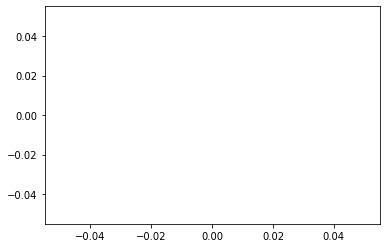

In [10]:
scores, n_iters = agent.train(NUM_EPISODES, MAX_ITERATIONS)
plt.plot(n_iters)

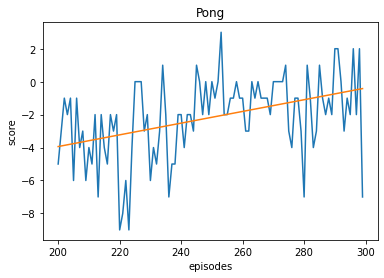

In [11]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

# sns.set()
x = range(INIT_EPISODE,NUM_EPISODES+INIT_EPISODE)
plt.plot(x,scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Pong')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(x,y_pred)
plt.show()

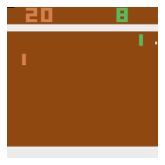

In [12]:
import cv2
def animate():
    frames = []
    state = env.reset()
    done = False
    while not done:
        frames.append(cv2.resize(env.render(mode='rgb_array'), (200, 200)))
        action = np.argmax(agent.model.predict(np.expand_dims(state,axis = 0)), axis=1)[0]
        state, _, done, _ = env.step(action)
    return frames
display.HTML(display_anim(animate(),fps = 24))
pass